# Define Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sin, sqrt, pi, exp

import time

In [8]:
x = np.concatenate([np.linspace(0,20,500), np.linspace(0,20,500)])

func_y = lambda x : sin(x) + 0.1*x + 3 + np.random.normal(0,0.2)
gen_y = (func_y(i) for i in x)

In [9]:
data = pd.DataFrame({"x": x, "y": gen_y})

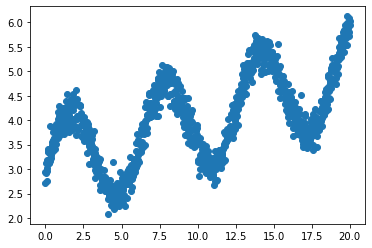

In [10]:
plt.scatter(x=data["x"], y=data["y"])

In [334]:
class KernelRegression:
    def __init__(self, X, y, bandwidth):
        self.X = X
        self.y = y
        self.h = bandwidth
        self.n = len(X)
        
    def _get_gaussian_kernel(self, x1, x2):
        return 1 / (self.h * sqrt(2*pi))*exp(-0.5*((x1-x2) / self.h)**2)
    
    def _apply_kernel(self, x):
        kernel = self._get_gaussian_kernel
        return [kernel(x, x_i) for x_i in self.X]
        
    def _get_weight_vector(self, x_val, h=None):
        """
        returns scaled weight vector for given x.
        """
        if not h:
            h = self.h

        return self.n * np.divide(self._apply_kernel(x_val), np.sum([self._apply_kernel(x_i) for x_i in self.X], axis=0))
    
    def predict(self, x_pred):
        regresssion_func = lambda x: np.dot(self._get_weight_vector(x), self.y) / self.n
        return [regresssion_func(x_val) for x_val in x_pred]

In [335]:
ke = KernelRegression(data.x.values, data.y.values, 0.1)
x_predict = np.linspace(0,10,30)
predictions = ke.predict(x_predict)

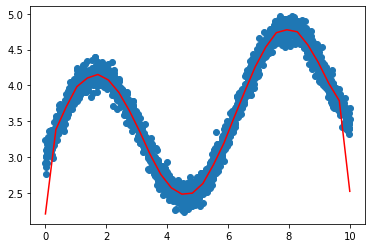

In [336]:
plt.scatter(x=data["x"], y=data["y"])
plt.plot(x_predict, predictions, c="red")

In [11]:
def time_it(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("Execution: {}".format(end - start))
        return result, end-start
    return wrapper

In [16]:
@time_it
def do_kr(class_obj, x, y, h):
    kr = class_obj(x, y, h)
    x_predict = np.linspace(0,20,30)
    predictions = kr.predict(x_predict)
    
    print(predictions)
    plt.scatter(x=x, y=y)
    plt.plot(x_predict, predictions, c="red")

[2.204707290208295, 3.3852248320071374, 3.7062111427464073, 3.9836539351543676, 4.103990213784552, 4.153518666909504, 4.07600512688966, 3.901273616387106, 3.6469092409612114, 3.350704247615579, 3.028981229647323, 2.7551658165195785, 2.569122225984584, 2.4809482531409004, 2.4950823957746477, 2.6293399601461056, 2.8893344238771252, 3.191291448264359, 3.5602664412330958, 3.9188372947077177, 4.26333471737107, 4.537255704823436, 4.737409253535316, 4.778129482429343, 4.749391705523778, 4.5673494728937385, 4.3213373696320465, 4.0288070972546715, 3.786714327902566, 2.5203994502179996]
Execution: 254.26171588897705


(None, 254.26171588897705)

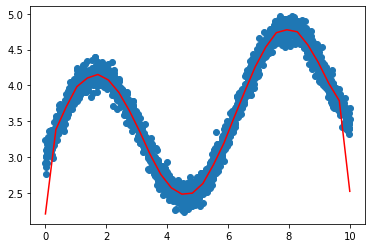

In [339]:
do_kr(KernelRegression, data.x.values, data.y.values, 0.1)

# Tweak performance

## 1. with numpy.vectorize

In [82]:
class KernelRegression:
    def __init__(self, X, y, bandwidth):
        self.X = X
        self.y = y
        self.h = bandwidth
        self.n = len(X)
        
    def _get_gaussian_kernel(self, x1, x2):
        return 1 / (self.h * sqrt(2*pi))*exp(-0.5*((x1-x2) / self.h)**2)
    
    def _apply_kernel(self, x):
        kernel = self._get_gaussian_kernel        
        return [kernel(x, x_i) for x_i in self.X]
        
    def _get_weight_vector(self, x_val, h=None):
        """
        returns scaled weight vector for given x.
        """
        if not h:
            h = self.h
            
        v_apply_kernel = np.vectorize(self._apply_kernel, otypes=[float])
    
        return np.divide(np.multiply(self.n, self._apply_kernel(x_val)), np.sum(v_apply_kernel(x_val), axis=0))
    
    def predict(self, x_pred):
        regresssion_func = lambda x: np.dot(self._get_weight_vector(x), self.y) / self.n
        v_regression_func = np.vectorize(regresssion_func, otypes=[float])
        return [regresssion_func(x_val) for x_val in x_pred]

In [14]:
# just a helper snippet to see bottlenecks
test = KernelRegression(data.x.values, data.y.values, 0.1)
@time_it
def testit():
    test._get_weight_vector(1)

print(sum([testit()[1] for _ in range(10)])/10)

Execution: 0.007493495941162109
Execution: 0.006051301956176758
Execution: 0.006674528121948242
Execution: 0.003259897232055664
Execution: 0.006386995315551758
Execution: 0.003961324691772461
Execution: 0.0034492015838623047
Execution: 0.0058269500732421875
Execution: 0.004049062728881836
Execution: 0.0034990310668945312
0.0050651788711547855


[2.934288968994194, 3.7038048427393666, 4.085895714734094, 4.14853873399028, 3.684689509455122, 3.0611293302465756, 2.4993982652232622, 2.5431358119684155, 2.9305874173817696, 3.4734011939875855, 4.249630819989386, 4.682095232659075, 4.817993942962861, 4.3130640081240434, 3.7929989503332213, 3.2924564202595463, 2.990425946846197, 3.4736832981085533, 4.041104482002915, 4.86583094501925, 5.4136168892765255, 5.396992763387363, 5.049493433222564, 4.337584164777175, 3.9029704355567283, 3.5988992036510843, 3.9021108773577136, 4.629563125021441, 5.401815613711508, 5.9674323399023645]
Execution: 0.1697239875793457


(None, 0.1697239875793457)

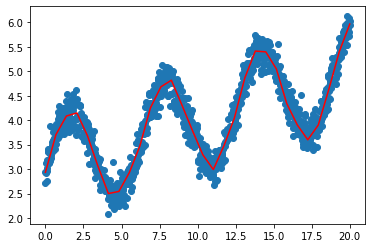

In [17]:
do_kr(KernelRegression, data.x.values, data.y.values, 0.05)

## 2. with numba.jit

In [176]:
from numba import int64, float64
from numba import types, typeof, typed
from numba.experimental import jitclass

In [358]:
spec = [
    ('X', typeof(data.x.values)),
    ('y', typeof(data.y.values)),
    ('h', float64),
    ('n', int64)
]

@jitclass(spec)
class KernelRegression:
    def __init__(self, X, y, bandwidth):
        self.X = X
        self.y = y
        self.h = bandwidth
        self.n = len(X)

    def _get_gaussian_kernel(self, x1, x2):
        return 1 / (self.h * sqrt(2*pi))*exp(-0.5*((x1-x2) / self.h)**2)
    
    def _apply_kernel(self, x):
#         res = typed.List.empty_list(types.float64)
        res = np.zeros(self.n)
        for i in range(self.n):
            res[i] = self._get_gaussian_kernel(x, self.X[i])
        return res
        
    def _get_weight_vector(self, x_val, h=None):
        """
        returns scaled weight vector for given x.
        """
        if not h:
            h = self.h
            
#         nominator = typed.List.empty_list(types.float64)
#         denominator = typed.List.empty_list(types.float64)
        
        nominator = np.multiply(self.n, self._apply_kernel(x_val))
        denominator = np.zeros(self.n)
        
        for i in range(self.n):
            denominator[i] = np.sum(self._apply_kernel(self.X[i]), axis=0)
        return np.divide(nominator, denominator)
    
    def predict(self, x_pred):
        res = np.zeros(len(x_pred))
        for i in range(len(x_pred)):
            res[i] = np.dot(self._get_weight_vector(x_pred[i]), (self.y)) / self.n
        return res

[2.23855228 3.36128849 3.71229426 4.00160993 4.09473146 4.14979915
 4.07735794 3.90511193 3.62773326 3.34843792 3.02648662 2.74765069
 2.5672372  2.47299704 2.48696649 2.62228428 2.8892214  3.19578899
 3.55459868 3.91501277 4.25921804 4.53800488 4.73897563 4.77677423
 4.75345964 4.55840079 4.32782787 4.02290313 3.7668943  2.58486654]
Execution: 3.5663974285125732


(None, 3.5663974285125732)

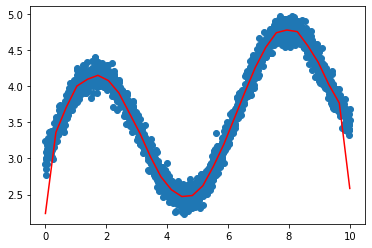

In [359]:
do_kr(KernelRegression, data.x.values, data.y.values, 0.05)

In [360]:
# numpy ist a bissi schnöller

# Compare with Statsmodels

In [340]:
from statsmodels.nonparametric.kernel_regression import KernelReg

In [342]:
kr = KernelReg(endog=data.y.values, exog=data.x.values, var_type="c")

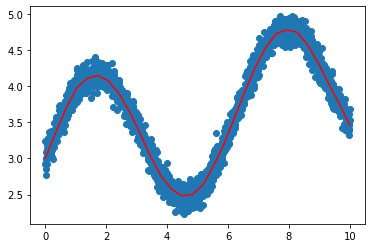

In [347]:
plt.scatter(data.x, data.y)
plt.plot(np.linspace(0,10,30), kr.fit(np.linspace(0,10,30))[0], c="red")

# Evaluate

In [18]:
# parameters: bandwidth h, kernel type

In [84]:
def evaluate(model_obj, x_eval, y_true):
    y_predicted = model_obj.predict(x_eval)
    
    rmse = np.sqrt(np.mean(np.subtract(y_true, y_predicted) ** 2))
    r_2 = 1 - np.divide(np.sum(np.subtract(y_true, y_predicted)**2) , np.sum(np.subtract(y_true, np.mean(y_true))**2))
    
    print(f"RMSE: {rmse}")
    print(f"R²: {r_2}")
    return rmse, r_2

In [85]:
kr = KernelRegression(data.x.values, data.y.values, 0.1)
evaluate(kr, data.x.values, data.y.values)

RMSE: 0.18692788809621416
R²: 0.9528706389996386


(0.18692788809621416, 0.9528706389996386)

# Make Class sklearn-compatible

In [138]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [167]:
class KernelRegression(BaseEstimator):
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        
    def _get_gaussian_kernel(self, x1, x2):
        return 1 / (self.bandwidth * sqrt(2*pi))*exp(-0.5*((x1-x2) / self.bandwidth)**2)
    
    def _apply_kernel(self, x):
        kernel = self._get_gaussian_kernel        
        return [kernel(x, x_i) for x_i in self._X]
        
    def _get_weight_vector(self, x_val):
        """
        returns scaled weight vector for given x.
        """
            
        v_apply_kernel = np.vectorize(self._apply_kernel, otypes=[float])
    
        return np.divide(np.multiply(self._n, self._apply_kernel(x_val)), np.sum(v_apply_kernel(x_val), axis=0))
    
    def fit(self, X, y):
        X, y = check_X_y(X,y,accept_sparse=False)
        self._X = X[:,0]
        self._y = y
        self._n = len(X)
        
        self._is_fitted = True
        
        return self
    
    def predict(self, x_pred):
        x_pred = check_array(x_pred, accept_sparse=False)
        check_is_fitted(self, '_is_fitted')
        regresssion_func = lambda x: np.dot(self._get_weight_vector(x), self._y) / self._n
        v_regression_func = np.vectorize(regresssion_func, otypes=[float])
        return np.array([regresssion_func(x_val) for x_val in x_pred[:,0]])

In [168]:
kr = KernelRegression(0.1)
check_estimator(kr)

/home/flo/tutorials/time-series/.venv/lib/python3.8/site-packages/sklearn/utils/estimator_checks.py:2979: FutureWarning: As of scikit-learn 0.23, estimators should expose a n_features_in_ attribute, unless the 'no_validation' tag is True. This attribute should be equal to the number of features passed to the fit method. An error will be raised from version 0.25 when calling check_estimator(). See SLEP010: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep010/proposal.html
  warnings.warn(


In [174]:
# reshape data to make it sklearn compatible
X = np.expand_dims(data.x.values, 1)
y = data.y.values

In [175]:
kr.fit(X, y)

KernelRegression(bandwidth=0.1)